In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_selection import SelectKBest, mutual_info_regression, RFECV
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import os
import ast

In [2]:
df = pd.read_csv("CleanData.csv", parse_dates=True)
df

,Category Name,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Property Features,Floors,Rooms,Toilets,Furnishing Sell,Price
0,Đất,108.158270,16.053888,102.0,5.0,23.0,4,6,8.0,['1 Part Residential'],0.0,0,0.0,0.0,165000000
1,Đất,108.172516,16.028736,100.0,5.0,20.0,4,5,6.0,"['No Residential', 'Back Expansion', '1 Part R...",0.0,0,0.0,0.0,250000000
2,Đất,108.136940,16.077059,100.0,5.0,20.0,4,5,4.0,"['No Residential', 'Back Expansion']",0.0,0,0.0,0.0,250000000
3,Đất,108.150030,16.066383,75.0,5.0,15.0,4,6,4.0,['No Residential'],0.0,0,0.0,0.0,280000000
4,Đất,108.172516,15.972230,153.0,5.0,30.0,1,1,5.0,"['Frontage', '1 Part Residential']",0.0,0,0.0,0.0,415000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,Nhà ở,108.241040,16.048594,100.0,5.0,20.0,0,1,2.0,['No thing'],3.0,3,3.0,2.0,12500000000
9967,Nhà ở,108.209236,16.034050,82.0,5.0,16.5,0,1,5.0,['No thing'],4.0,4,4.0,2.0,12699999999
9968,Nhà ở,108.175480,16.048260,100.0,5.0,20.0,0,1,6.0,['No thing'],3.0,3,3.0,2.0,3700000000
9969,Nhà ở,108.220825,16.031023,93.0,5.0,18.6,0,1,5.0,['No thing'],1.0,2,1.0,4.0,4800000000


In [3]:
def convert_to_list(value):
    if isinstance(value, str): 
        try:
            return ast.literal_eval(value)  
        except:
            return [value.strip()]  
    elif isinstance(value, list):
        return value 
    else:
        return [] 

### Ordinal Encoding

In [4]:
category_order = ['Đất', 'Nhà ở']

df['Category Name'] = pd.Categorical(df['Category Name'], categories=category_order, ordered=True)
label_encoder = OrdinalEncoder(categories=[category_order])
y_encoded = label_encoder.fit_transform(df[['Category Name']])
df['Category_Encoded'] = y_encoded
df[['Category Name', 'Category_Encoded']].head()

,Category Name,Category_Encoded
0,Đất,0.0
1,Đất,0.0
2,Đất,0.0
3,Đất,0.0
4,Đất,0.0


In [5]:
df = df.drop(columns=["Category Name"])

### One-hot encoding 

In [6]:
# df["Ward Name"] = df["Ward Name"].str.lower()
# df["Street Name"] = df["Street Name"].str.lower()

# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# encoded_columns = encoder.fit_transform(df[["Ward Name", "Street Name"]])

# encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(["Ward Name", "Street Name"]))

# df_final = df.drop(columns=["Ward Name", "Street Name"]).join(encoded_df)

# df_final.head()

In [7]:
df["Property Features"] = df["Property Features"].apply(convert_to_list)
mlb = MultiLabelBinarizer()

features_encoded = mlb.fit_transform(df["Property Features"])
df_features = pd.DataFrame(features_encoded, columns=mlb.classes_)

df = df.drop(columns=["Property Features"]).reset_index(drop=True)
# df_final = df_final.drop(columns=["Property Features"]).reset_index(drop=True)
df = pd.concat([df, df_features], axis=1)
df = df.drop(columns=["No thing"]).reset_index(drop=True)

df.head()

,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Floors,Rooms,Toilets,Furnishing Sell,Price,Category_Encoded,1 Part Residential,Back Expansion,Car Alley,Frontage,No Residential
0,108.158270,16.053888,102.0,5.0,23.0,4,6,8.0,0.0,0,0.0,0.0,165000000,0.0,1,0,0,0,0
1,108.172516,16.028736,100.0,5.0,20.0,4,5,6.0,0.0,0,0.0,0.0,250000000,0.0,1,1,0,0,1
2,108.136940,16.077059,100.0,5.0,20.0,4,5,4.0,0.0,0,0.0,0.0,250000000,0.0,0,1,0,0,1
3,108.150030,16.066383,75.0,5.0,15.0,4,6,4.0,0.0,0,0.0,0.0,280000000,0.0,0,0,0,0,1
4,108.172516,15.972230,153.0,5.0,30.0,1,1,5.0,0.0,0,0.0,0.0,415000000,0.0,1,0,0,1,0


## Feature Transformation

### Normalize using Arcsine method

In [8]:
columns_to_asinh = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
df_asinh_transformed = df.copy()
df_asinh_transformed[columns_to_asinh] = np.arcsinh(df_asinh_transformed[columns_to_asinh])
df_asinh_transformed[columns_to_asinh].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,19.614603,5.376764,3.470067,5.318144,2.312438,3.829114,0.0,0.0,0.0
1,20.030119,5.376896,3.468502,5.298342,2.312438,3.689504,0.0,0.0,0.0
2,20.030119,5.376567,3.471506,5.298342,2.312438,3.689504,0.0,0.0,0.0
3,20.143447,5.376688,3.470843,5.010680,2.312438,3.402307,0.0,0.0,0.0
4,20.536936,5.376896,3.464977,5.723596,2.312438,4.094622,0.0,0.0,0.0


### Normalization using Z-score method

In [9]:
columns_to_zScore = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
std_scaler_zScore = StandardScaler()
df_std_scaled_zScore = std_scaler_zScore.fit_transform(df[columns_to_zScore])
df_std_scaled_zScore = pd.DataFrame(df_std_scaled_zScore, columns=columns_to_zScore)
df_std_scaled_zScore[columns_to_zScore].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,-1.975460,-1.303268,0.428250,0.479057,0.0,1.057445,-0.849345,-0.831964,-0.811842
1,-1.935177,-0.916296,-0.248426,0.390465,0.0,0.391201,-0.849345,-0.831964,-0.811842
2,-1.935177,-1.882666,1.051631,0.390465,0.0,0.391201,-0.849345,-0.831964,-0.811842
3,-1.920959,-1.527095,0.764409,-0.716929,0.0,-0.719205,-0.849345,-0.831964,-0.811842
4,-1.856980,-0.916296,-1.768635,2.738142,0.0,2.612014,-0.849345,-0.831964,-0.811842


### Normalize using Logarithmic method

In [10]:
columns_to_log = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
df_log_transformed = df.copy()
df_log_transformed = df[columns_to_log].apply(np.log1p)
df_log_transformed = pd.DataFrame(df_log_transformed, columns=columns_to_log)
df_log_transformed[columns_to_log].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,18.921456,4.692799,2.836378,4.634729,1.791759,3.178054,0.0,0.0,0.0
1,19.336971,4.692929,2.834902,4.615121,1.791759,3.044522,0.0,0.0,0.0
2,19.336971,4.692603,2.837736,4.615121,1.791759,3.044522,0.0,0.0,0.0
3,19.450300,4.692723,2.837111,4.330733,1.791759,2.772589,0.0,0.0,0.0
4,19.843789,4.692929,2.831578,5.036953,1.791759,3.433987,0.0,0.0,0.0


### Normalize using square root method

In [11]:
columns_to_sqrt = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]
df_sqrt_transformed = df.copy()
df_sqrt_transformed = df[columns_to_sqrt].apply(np.sqrt)
df_sqrt_transformed = pd.DataFrame(df_sqrt_transformed, columns=columns_to_sqrt)
df_sqrt_transformed[columns_to_sqrt].head()

,Price,Longitude,Latitude,Area (m²),Width (m),Length (m),Floors,Rooms,Toilets
0,12845.232579,10.399917,4.006730,10.099505,2.236068,4.795832,0.0,0.0,0.0
1,15811.388301,10.400602,4.003590,10.000000,2.236068,4.472136,0.0,0.0,0.0
2,15811.388301,10.398891,4.009621,10.000000,2.236068,4.472136,0.0,0.0,0.0
3,16733.200531,10.399521,4.008289,8.660254,2.236068,3.872983,0.0,0.0,0.0
4,20371.548787,10.400602,3.996527,12.369317,2.236068,5.477226,0.0,0.0,0.0


### Data verification

*Histogram comparing the variable Price before and after normalization*

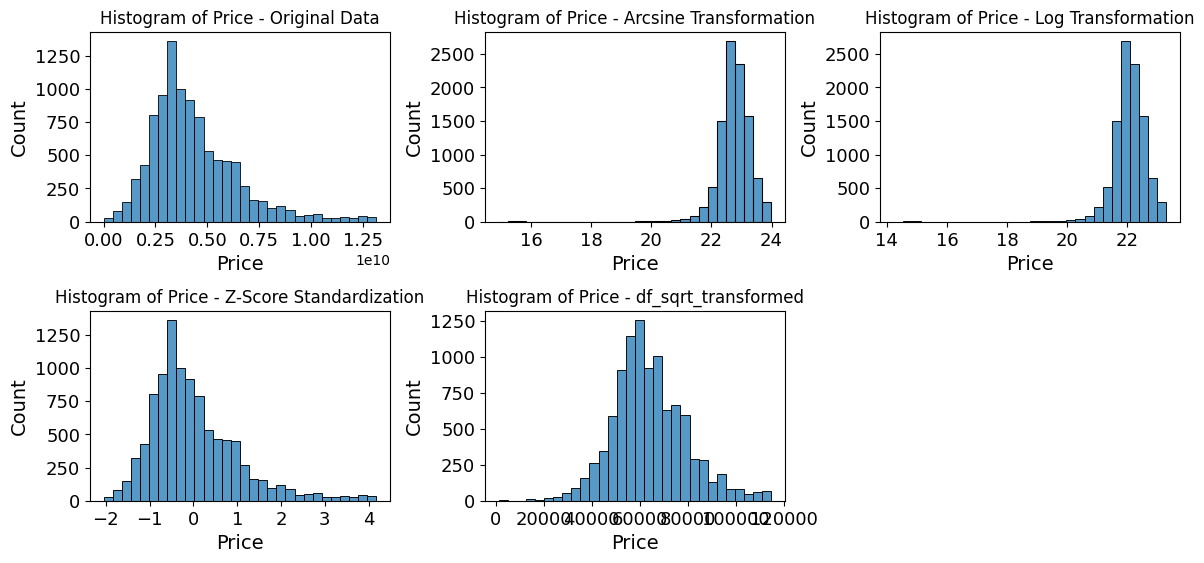

In [12]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Price'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Price', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Price - {method}')
    plt.tight_layout()

plt.show()

*Histogram comparing the variable Area (m²) before and after normalization*

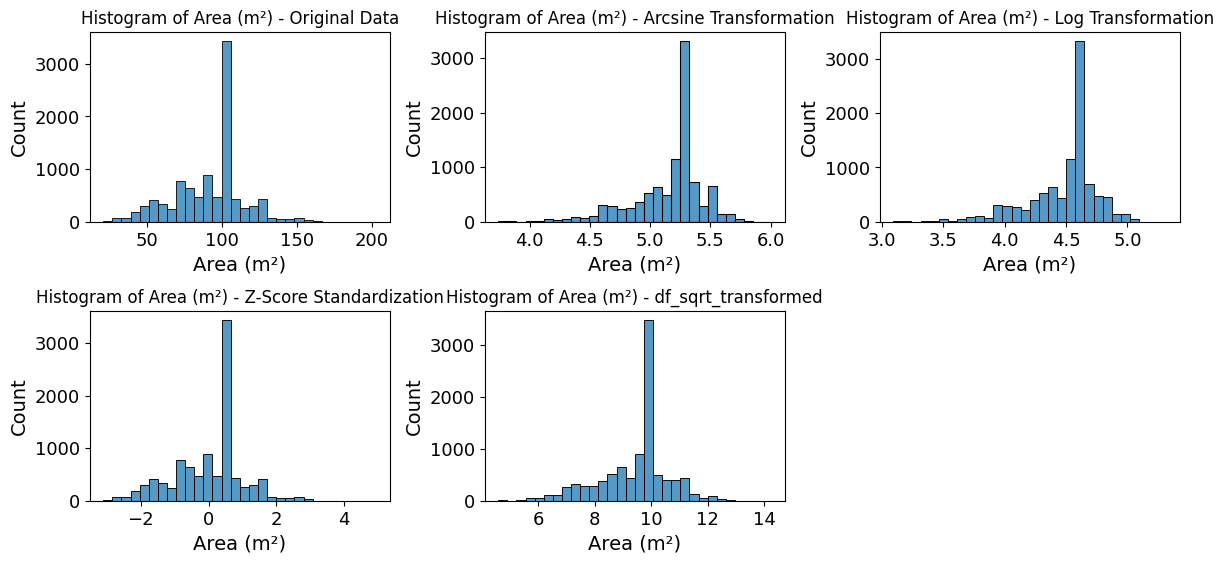

In [13]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']
plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    sns.histplot(data=data['Area (m²)'], bins=30)
    plt.ylabel('Count', fontsize = 14)
    plt.xlabel('Area (m²)', fontsize = 14)
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.title(f'Histogram of Area (m²) - {method}')
    plt.tight_layout()

plt.show()

*Use probability graph to verify whether the transformed data follows the normal distribution*

- Comparison of the distribution of the *Price* feature when applying normalization methods

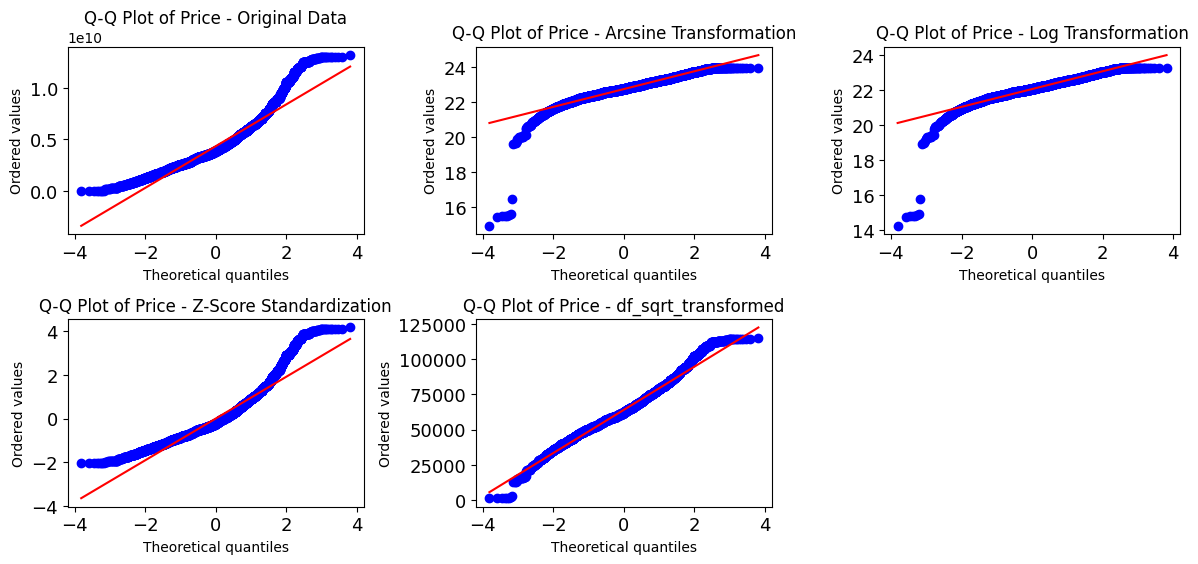

In [14]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Price'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Price - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Area (m²)* feature when applying normalization methods

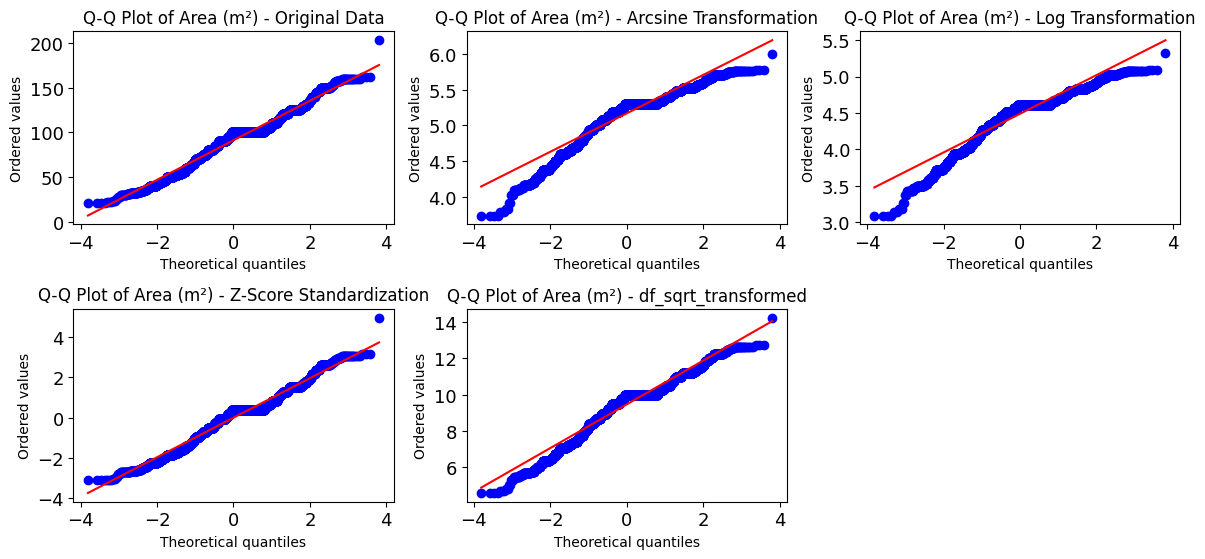

In [15]:
dfs = [df,df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Area (m²)'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Area (m²) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Width (m)* feature when applying normalization methods

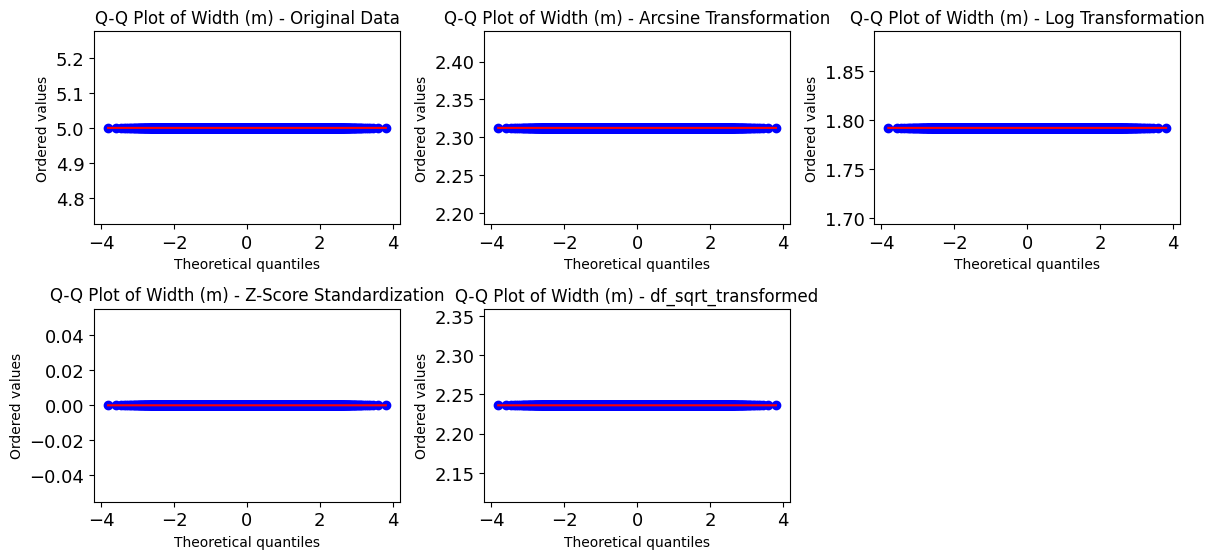

In [16]:
dfs = [df,  df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'df_sqrt_transformed']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Width (m)'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Width (m) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Longitude* feature when applying normalization methods

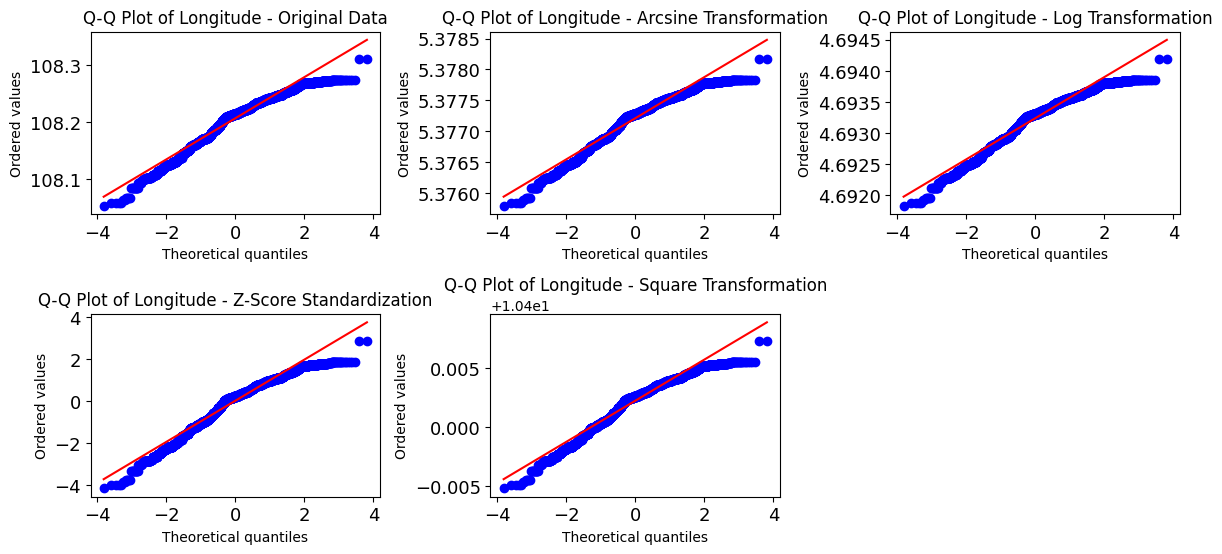

In [17]:
dfs = [df,  df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Longitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Longitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Comparison of the distribution of the *Latitude* feature when applying normalization methods

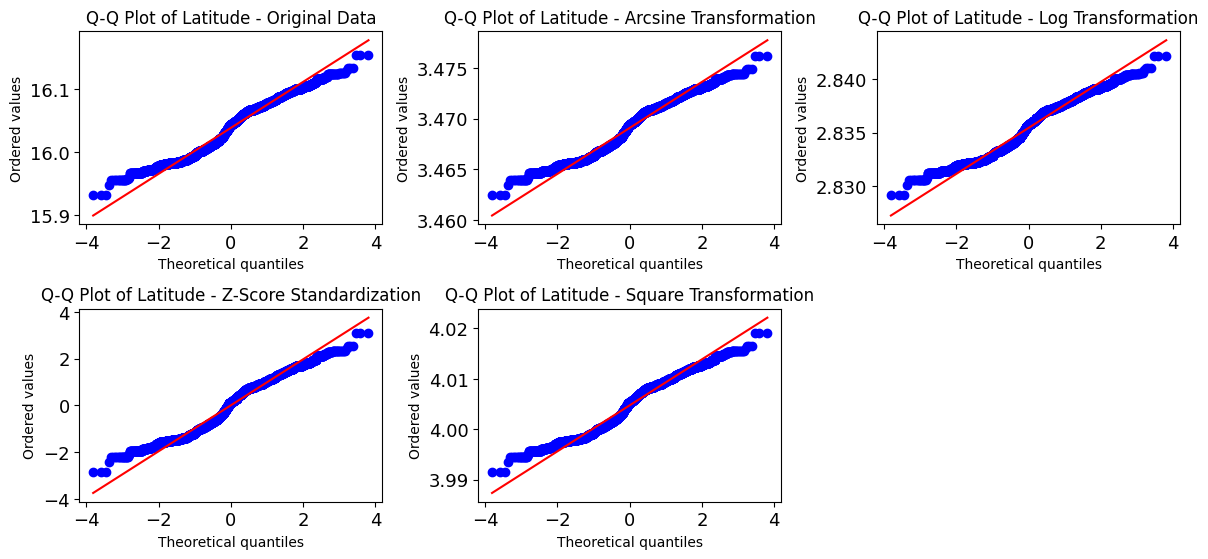

In [18]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data['Latitude'], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Latitude - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Floors* when applying standardized methods

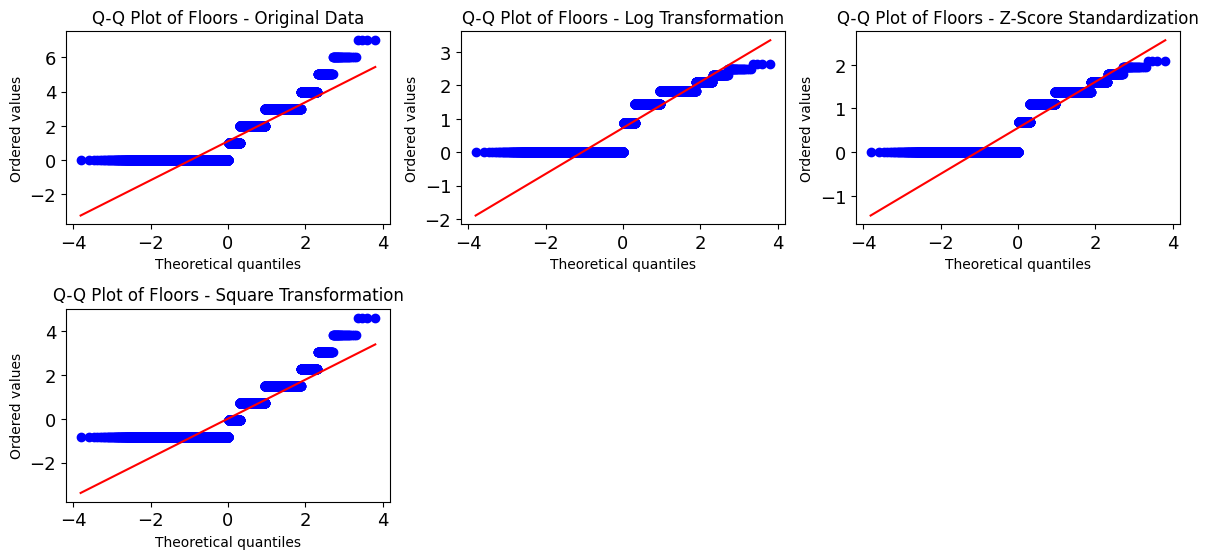

In [19]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Floors"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Floors - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Rooms* when applying standardized methods

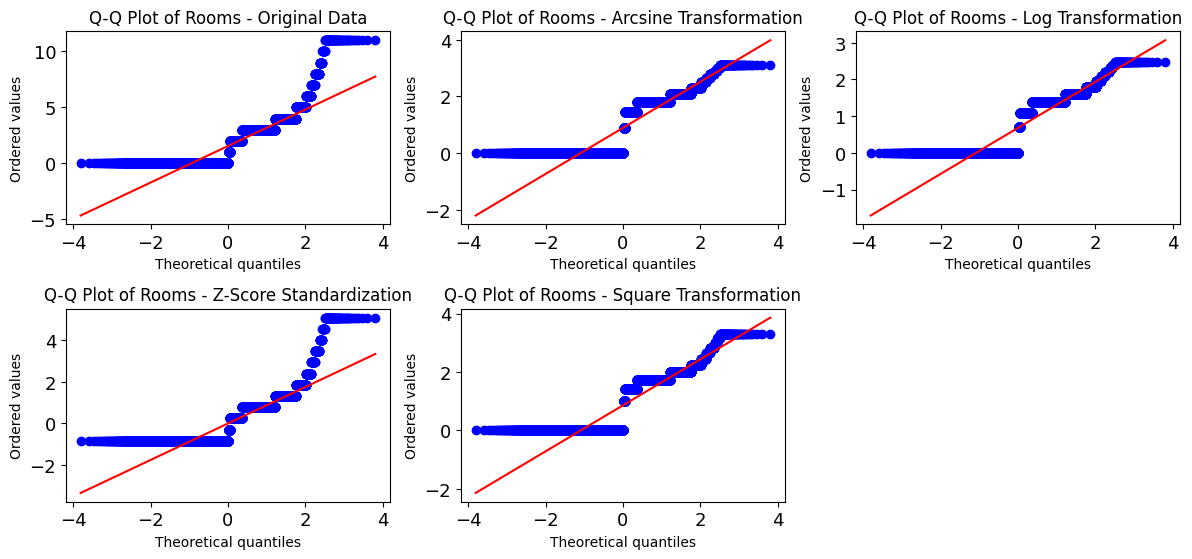

In [20]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data",'Arcsine Transformation', 'Log Transformation', 'Z-Score Standardization', 'Square Transformation']

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Rooms"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Rooms - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Toilets* when applying standardized methods

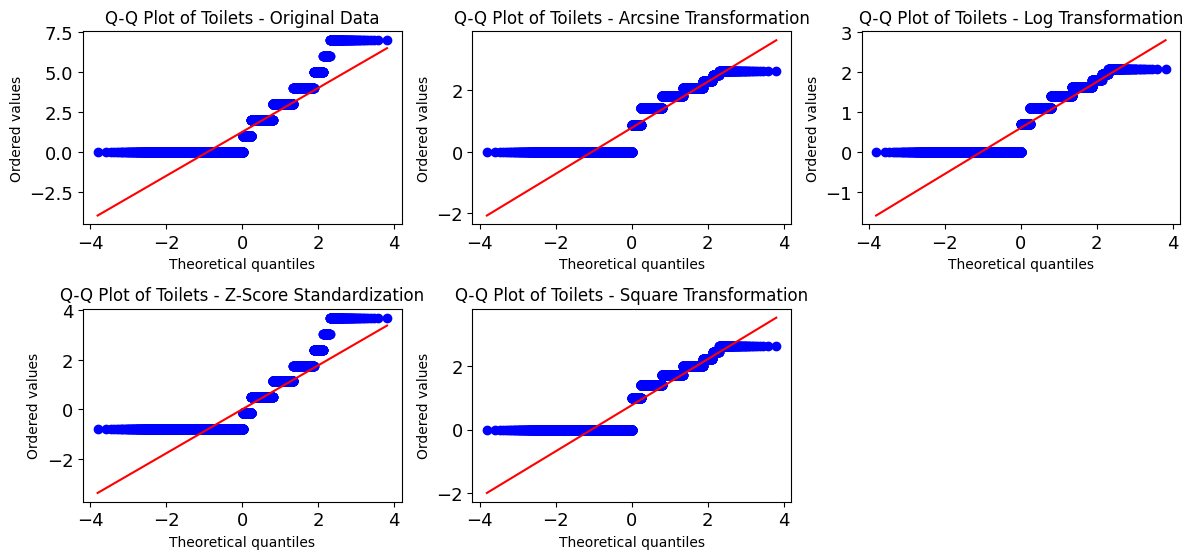

In [21]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Arcsine Transformation", "Log Transformation", "Z-Score Standardization", "Square Transformation"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Toilets"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Toilets - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

*The characteristic that follows the most normal distribution is standardized by the square root method.*

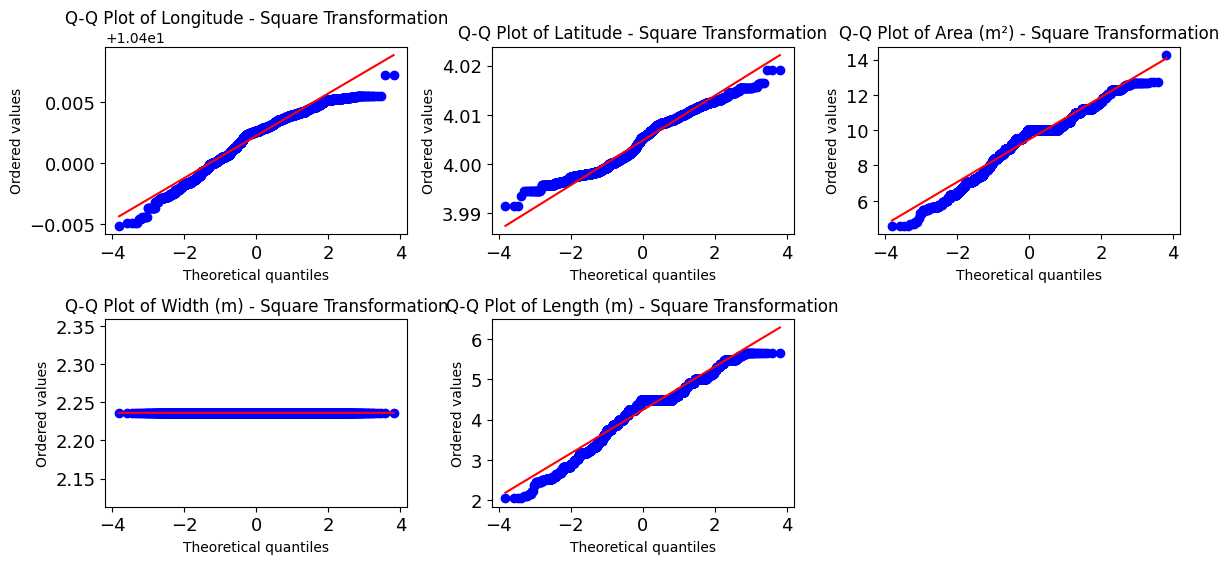

In [22]:
cols = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_sqrt_transformed[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col} - Square Transformation")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

- Compares distribution of characteristics *Length (m)* when applying standardized methods

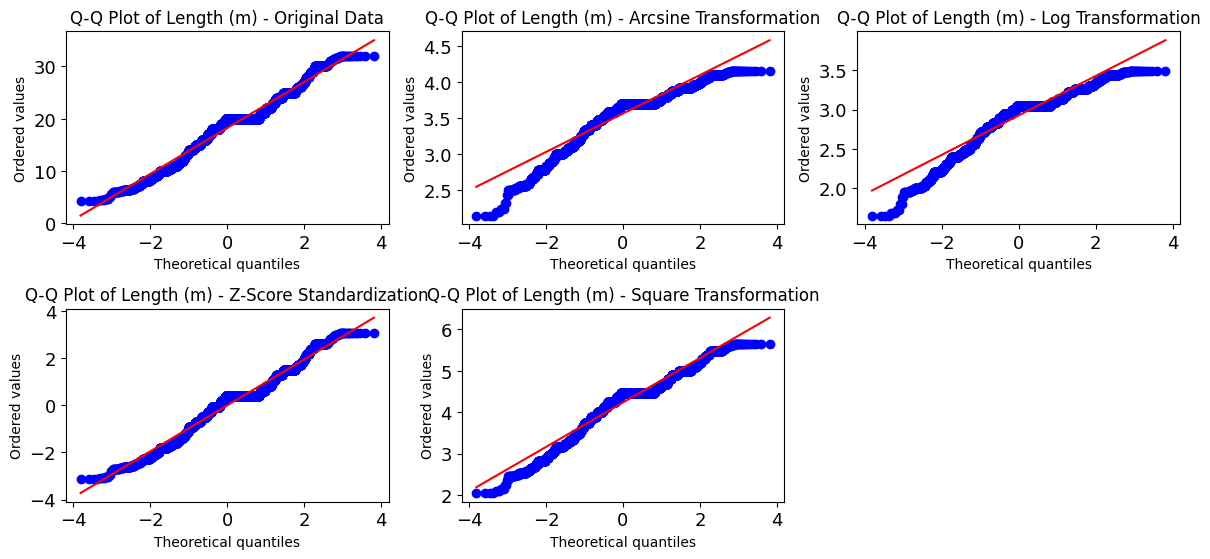

In [23]:
dfs = [df, df_asinh_transformed, df_log_transformed, df_std_scaled_zScore, df_sqrt_transformed]
methods = ["Original Data", "Arcsine Transformation", "Log Transformation", "Z-Score Standardization", "Square Transformation"]

plt.figure(figsize=(12, 8))
for i, (data, method) in enumerate(zip(dfs, methods), 1):
    plt.subplot(3, 3, i) 
    stats.probplot(data["Length (m)"], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of Length (m) - {method}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

=> Select Z-Score normalization method for feature *Length (m)* & *Price* and Square root method for features *Longitude, Latitude, Area (m²), Width (m), Floors, Rooms, Toilets*

In [24]:
df_final = df.copy()

df_final["Length (m)"] = df_std_scaled_zScore["Length (m)"]
df_final["Price"] = df_std_scaled_zScore["Price"]
columns_sqrt = ["Longitude", "Latitude", "Area (m²)", "Width (m)", "Floors", "Rooms", "Toilets"]
df_final[columns_sqrt] = df_sqrt_transformed[columns_sqrt]

df_final.head()


,Longitude,Latitude,Area (m²),Width (m),Length (m),Land Type,Legal Status,House Direction,Floors,Rooms,Toilets,Furnishing Sell,Price,Category_Encoded,1 Part Residential,Back Expansion,Car Alley,Frontage,No Residential
0,10.399917,4.006730,10.099505,2.236068,1.057445,4,6,8.0,0.0,0.0,0.0,0.0,-1.975460,0.0,1,0,0,0,0
1,10.400602,4.003590,10.000000,2.236068,0.391201,4,5,6.0,0.0,0.0,0.0,0.0,-1.935177,0.0,1,1,0,0,1
2,10.398891,4.009621,10.000000,2.236068,0.391201,4,5,4.0,0.0,0.0,0.0,0.0,-1.935177,0.0,0,1,0,0,1
3,10.399521,4.008289,8.660254,2.236068,-0.719205,4,6,4.0,0.0,0.0,0.0,0.0,-1.920959,0.0,0,0,0,0,1
4,10.400602,3.996527,12.369317,2.236068,2.612014,1,1,5.0,0.0,0.0,0.0,0.0,-1.856980,0.0,1,0,0,1,0


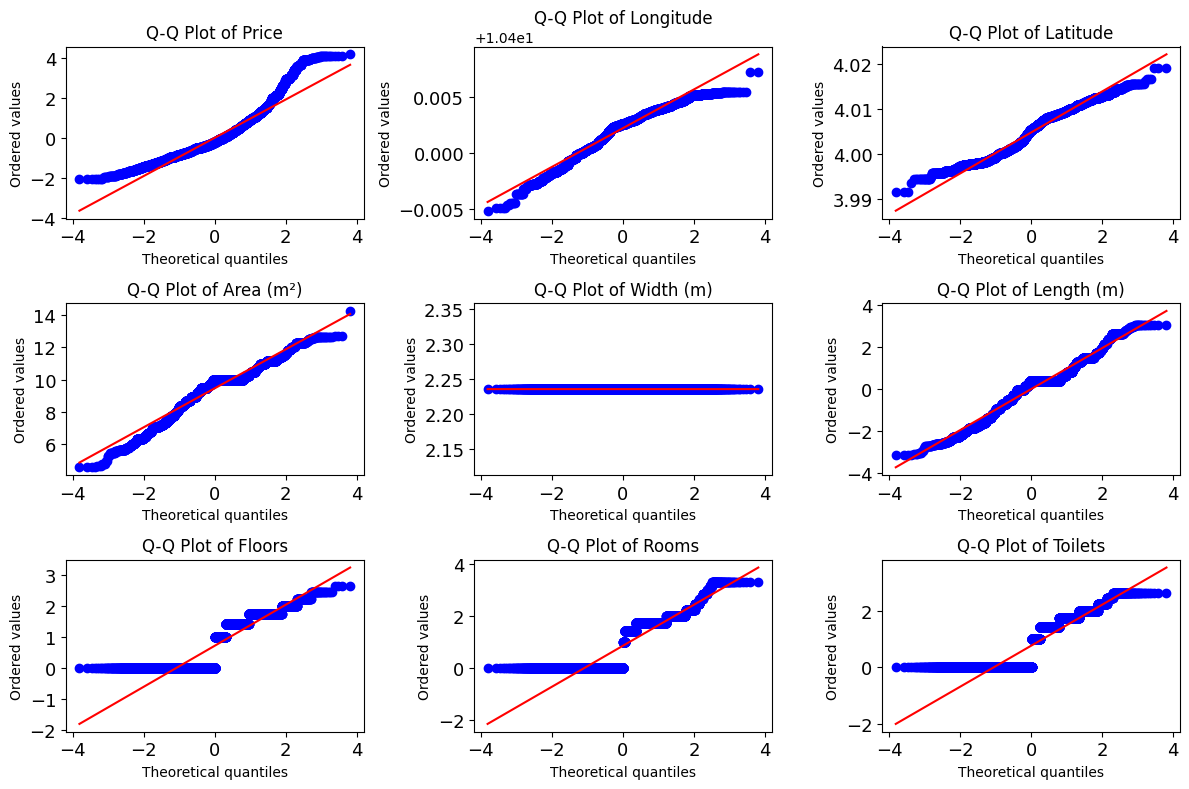

In [25]:
cols = ["Price", "Longitude", "Latitude", "Area (m²)", "Width (m)", "Length (m)", "Floors", "Rooms", "Toilets"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(3, 3, i) 
    stats.probplot(df_final[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.xlabel("Theoretical quantiles")
    plt.ylabel("Ordered values")
    plt.xticks(fontsize=13)  
    plt.yticks(fontsize=13) 
    plt.tight_layout()

plt.show()

In [26]:
# Get mean and std from scaler
means = std_scaler_zScore.mean_
stds = std_scaler_zScore.scale_

# Create DataFrame for statistics
stats = {
    'Metric': ['mean', 'std'],
    'price': [means[0], stds[0]],  # Assuming Price is the second column
    'length': [means[5], stds[5]]  # Assuming Length is the first column
}
# Thư mục mới để lưu file
output_dir = '../../Backend/src/main/resources/'

# Tạo thư mục nếu chưa tồn tại
os.makedirs(output_dir, exist_ok=True)

df_stats = pd.DataFrame(stats)

df_stats.to_csv('scaler_params.csv', index=False)
# Lưu file vào thư mục mới
output_path = os.path.join(output_dir, 'scaler_params.csv')
df_stats.to_csv(output_path, index=False)

print(f"File '{output_path}' has been successfully created!")
print("File 'scaler_params.csv' has been successfully created!")

File '../../Backend/src/main/resources/scaler_params.csv' has been successfully created!
File 'scaler_params.csv' has been successfully created!


In [27]:
df_final.to_csv('TransformedData.csv', index=False)
print("DataFrame exported to CSV file.")

DataFrame exported to CSV file.
